In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from constant import AFFECTNETPATH

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file,base_path,transform=None):
        self.fields = ['subDirectory_filePath', 'expression','valence','arousal']
        self._table = pd.read_csv(csv_file,usecols=self.fields)
        
        self._table=self._table[self._table['expression'] <8]

        self._table=self._table.reset_index(drop=True)

        self._base_path=base_path
   



        self.transform=transforms.Compose([
                     transforms.Resize((64,64)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])

    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path,self._table.subDirectory_filePath[idx])
        img=Image.open(folder_name)
        img=self.transform(img)
        valence = torch.from_numpy(np.array(self._table.valence[idx]))
        return (img,valence.float())
            
        

In [3]:
Affect_Train=ImageDataset('training.csv',AFFECTNETPATH)
Affect_Valid=ImageDataset('validation.csv',AFFECTNETPATH)

In [4]:
import csv
def import_data(filename):
    """Import data in the second column of the supplied filename as floats."""
    with open(filename, 'r') as inf:
        inf.readline()
        return [float(row[2]) for row in csv.reader(inf)]

In [5]:
len(Affect_Train)

287652

In [6]:
train_dataloader = DataLoader(Affect_Train, batch_size=256
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(Affect_Valid, batch_size=256
                       , num_workers=0)    

In [7]:
len(train_dataloader)

1124

In [8]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)


for name, child in resnet18.named_children():
    if not name in []:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
               param.requires_grad = False
                
                

conv1 is unfrozen
bn1 is unfrozen
relu is unfrozen
maxpool is unfrozen
layer1 is unfrozen
layer2 is unfrozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is unfrozen
fc is unfrozen


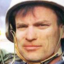

In [9]:
img=transforms.ToPILImage()(Affect_Train[26][0]*0.5+0.5)
img


In [10]:
from module import face_feature

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

model=face_feature.Face_Feature(resnet18)


model=model.to(device)

In [12]:
device

device(type='cuda', index=0)

In [13]:
#from torchsummary import summary
#summary(model,(3,64,64))

In [14]:
model(Affect_Train[0][0].unsqueeze(0).to(device))

tensor([[-0.7765]], grad_fn=<TanhBackward>)

In [15]:
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, betas=(0.5, 0.999))

In [16]:
from tqdm.notebook import tqdm

In [17]:
len(train_dataloader)

1124

In [18]:
train_loss=[]
val_loss=[]
num_epochs=50

for epochs in (range(0,num_epochs)):
    model.train()
    print("Training Epoch: ", epochs+1,"\n")
   
    for i_batch, (img,valence) in tqdm(enumerate(train_dataloader)):
        batch_size=img.size(0)
        optimizer.zero_grad()
        img=img.to(device)
        val_output=model(img)
        loss=loss_func(val_output,valence.to(device))
        loss.backward()
        optimizer.step()
        if i_batch%500==0:
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("MSE loss: ", loss.item())
            train_loss.append(loss.item())
    model.eval()
    avg_loss=1e6
    temp_loss=0
    for i_batch, (img,valence) in enumerate(valid_dataloader):
        
        batch_size=img.size(0)

        img=img.to(device)
        val_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        temp_loss+=loss1.item()
    avg_temp_loss=    temp_loss/len(valid_dataloader)
    print("ValidationLoss: ",avg_temp_loss)
    val_loss.append(avg_temp_loss)
    if avg_temp_loss<avg_loss:
        avg_loss=avg_temp_loss
        torch.save(model,"face_feature.h")
    

    

    
        

Training Epoch:  1 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Batch:  1 / 1124
MSE loss:  0.8641905188560486
Batch:  501 / 1124
MSE loss:  0.4740753173828125
Batch:  1001 / 1124
MSE loss:  0.4370391070842743


/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([164])) that is different to the input size (torch.Size([164, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)



ValidationLoss:  0.5525660626590252
Training Epoch:  2 



/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Face_Feature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for containe

Batch:  1 / 1124
MSE loss:  0.4402770400047302
Batch:  501 / 1124
MSE loss:  0.45207110047340393
Batch:  1001 / 1124
MSE loss:  0.442383348941803

ValidationLoss:  0.5613006167113781
Training Epoch:  3 



Batch:  1 / 1124
MSE loss:  0.46387019753456116
Batch:  501 / 1124
MSE loss:  0.43922555446624756
Batch:  1001 / 1124
MSE loss:  0.48780372738838196

ValidationLoss:  0.5622653067111969
Training Epoch:  4 



Batch:  1 / 1124
MSE loss:  0.4803837537765503
Batch:  501 / 1124
MSE loss:  0.4869186282157898
Batch:  1001 / 1124
MSE loss:  0.4827970564365387

ValidationLoss:  0.5563184469938278
Training Epoch:  5 



Batch:  1 / 1124
MSE loss:  0.45526057481765747
Batch:  501 / 1124
MSE loss:  0.4333847165107727
Batch:  1001 / 1124
MSE loss:  0.4704796373844147

ValidationLoss:  0.5226161889731884
Training Epoch:  6 



Batch:  1 / 1124
MSE loss:  0.47010278701782227
Batch:  501 / 1124
MSE loss:  0.4393344521522522
Batch:  1001 / 1124
MSE loss:  0.4309175908565521

ValidationLoss:  0.5195681899785995
Training Epoch:  7 



Batch:  1 / 1124
MSE loss:  0.4005727171897888
Batch:  501 / 1124
MSE loss:  0.47701048851013184
Batch:  1001 / 1124
MSE loss:  0.45811256766319275

ValidationLoss:  0.5553683266043663
Training Epoch:  8 



Batch:  1 / 1124
MSE loss:  0.45160117745399475
Batch:  501 / 1124
MSE loss:  0.4486909508705139
Batch:  1001 / 1124
MSE loss:  0.45064041018486023

ValidationLoss:  0.5445472188293934
Training Epoch:  9 



Batch:  1 / 1124
MSE loss:  0.46894726157188416
Batch:  501 / 1124
MSE loss:  0.42819109559059143
Batch:  1001 / 1124
MSE loss:  0.46485036611557007

ValidationLoss:  0.5264794621616602
Training Epoch:  10 



Batch:  1 / 1124
MSE loss:  0.46664583683013916
Batch:  501 / 1124
MSE loss:  0.45091456174850464
Batch:  1001 / 1124
MSE loss:  0.4493559002876282

ValidationLoss:  0.5453268177807331
Training Epoch:  11 



Batch:  1 / 1124
MSE loss:  0.44770950078964233
Batch:  501 / 1124
MSE loss:  0.4485887289047241


KeyboardInterrupt: 

In [19]:
torch.save(model.resnet,"pre_trained_resnet18_face.h")

In [ ]:
torch.save(model.resnet.state_dict(), "pretrained_state_dict")

In [ ]:
print("hu")

In [ ]:
model